# Google Drive Connection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
import os
sys.path.append('/content/drive/MyDrive/Applied Analytics/Applied-Analytics_Few-Shot-AD/')

from utils import load_local_dataset

#base_path = "/Users/kaihorlacher/Documents/HochschuleAalen/Semester2/03_Machine Learning Research (Data Science)/Applied-Analytics_Few-Shot-AD"
#data_path = base_path + "/data/mechanicalseals"

#base_path_gd = "/content/drive/MyDrive/03 HS Aalen/Applied-Analytics_Few-Shot-AD" # TODO: insert path to your project
#data_path_gd = base_path_gd + "/data/mechanicalseals"

base_path = "/content/drive/MyDrive/Applied Analytics/Applied-Analytics_Few-Shot-AD" # TODO: insert path to your project
data_path = base_path + "/data/mechanicalseals"

Mounted at /content/drive


# Packages & Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers.legacy import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50, InceptionV3, Xception
from keras.applications.vgg16 import preprocess_input
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential, clone_model
from keras import backend as K
import datetime


#Pre-processed Images - Input jeweilige Modelle
from tensorflow.keras.applications.vgg16 import preprocess_input as pre_input_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as pre_input_resnet50
from tensorflow.keras.applications.inception_v3 import preprocess_input as pre_input_inception_v3
from tensorflow.keras.applications.xception import preprocess_input as pre_input_xception
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pandas as pd

from sklearn.metrics import confusion_matrix

import copy
import cv2

from skimage import exposure

# Data Preprocess & Reproductability

In [8]:
# Set seed for reproducibility
seed_value = 72
tf.random.set_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [9]:
#Data splitting
X, y = load_local_dataset(data_path, encoding="integer")


Dataset loaded: 181 images (shape: (224, 224, 3)), belonging to 2 classes.


In [10]:
# Preprocessing the images with original preprocess of its models

#List with names of the models
list_of_pre_images_models = ["VGG16", "ResNet50", "InceptionV3", "Xception"]

root_x = copy.copy(X)
root_x1 = copy.copy(X)
root_x2 = copy.copy(X)
root_x3 = copy.copy(X)

#Below are the models copied and preprocessed
X_preprocessed_images_vgg16 = copy.copy(X)
X_preprocessed_images_vgg16_rgb = []

for each1 in root_x:
  preprocessed_image1 = pre_input_vgg16(each1)
  X_preprocessed_images_vgg16_rgb.append(preprocessed_image1)

X_preprocessed_images_resnet50_rgb = []


for each2 in root_x1:
  preprocessed_image2 = pre_input_resnet50(each2)
  X_preprocessed_images_resnet50_rgb.append(preprocessed_image2)

X_preprocessed_images_inceptionv3_rgb = []

for each3 in root_x2:
    if each3.shape[2] == 3:
        # Skaling pixel areas from 0 to 255
        each3 = each3 * 255

        # Wende das Preprocessing an
        preprocessed_image_incep_299 = cv2.resize(each3, (299, 299))
        preprocessed_image3 = pre_input_inception_v3(preprocessed_image_incep_299)

        X_preprocessed_images_inceptionv3_rgb.append(preprocessed_image3)
    else:
        print("Error")


X_preprocessed_images_xception_rgb = []
for each4 in root_x3:
    if each4.shape[2] == 3:
        # Skaling pixel areas from 0 to 255
        each4 = each4 * 255

        # Wende das Preprocessing an
        preprocessed_image_xcep_299 = cv2.resize(each4, (299, 299))
        preprocessed_image4 = pre_input_xception(preprocessed_image_xcep_299)

        X_preprocessed_images_xception_rgb.append(preprocessed_image4)
    else:
        print("Error")



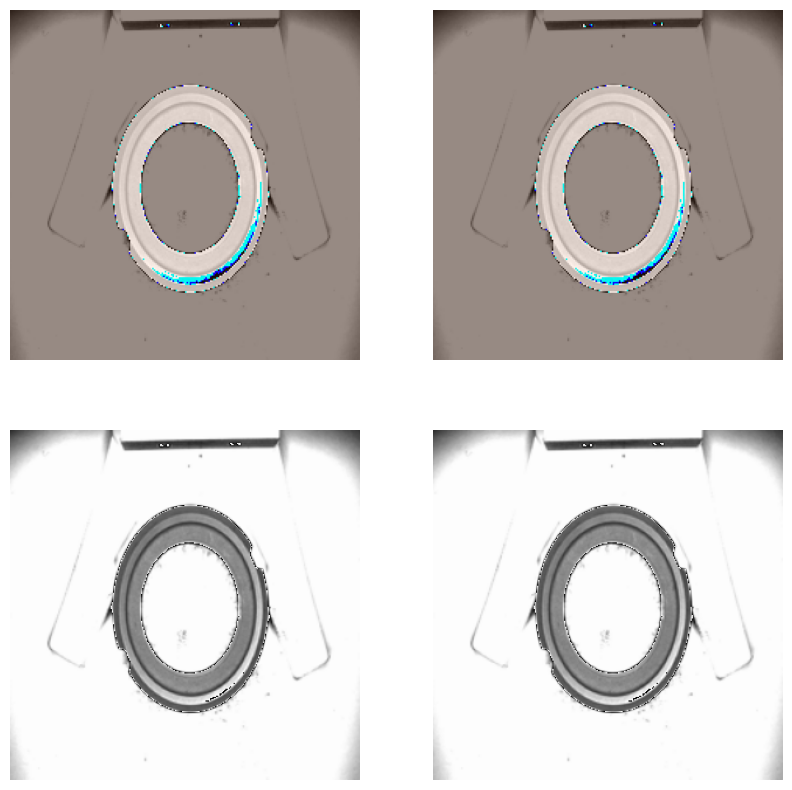

In [11]:
# Checking the images with its preprocess for more understanding (in a 2x2 plot)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
liste_pic = [X_preprocessed_images_vgg16_rgb[100].astype("uint8"),
             X_preprocessed_images_resnet50_rgb[100].astype("uint8"),
             (X_preprocessed_images_inceptionv3_rgb[100]).astype("uint8"),
             (X_preprocessed_images_xception_rgb[100]).astype("uint8")]

for i, ax in enumerate(axes.flat):
    ax.imshow(liste_pic[i])
    ax.axis('off')

plt.show()


In [12]:
#Creating splitted lists for X and y for each model because of its different preprocess method
X_undamaged_vgg16 = []
y_undamaged_vgg16 = []
X_damaged_vgg16 = []
y_damaged_vgg16 = []

X_undamaged_resnet50 = []
y_undamaged_resnet50 = []
X_damaged_resnet50 = []
y_damaged_resnet50 = []

X_undamaged_inceptionv3= []
y_undamaged_inceptionv3 = []
X_damaged_inceptionv3 = []
y_damaged_inceptionv3 = []

X_undamaged_xception = []
y_undamaged_xception = []
X_damaged_xception = []
y_damaged_xception = []

#Taking all data of X and y and iterating with for-clause to get the right split of undamaged and damaged
sample_count = 0


for element in X:
  #print(y[sample_count])
  #print(X[sample_count])

  if y[sample_count] == 1:
    X_damaged_vgg16.append(X_preprocessed_images_vgg16_rgb[sample_count])
    y_damaged_vgg16.append(y[sample_count])

    X_damaged_resnet50.append(X_preprocessed_images_resnet50_rgb[sample_count])
    y_damaged_resnet50.append(y[sample_count])

    X_damaged_inceptionv3.append(X_preprocessed_images_inceptionv3_rgb[sample_count])
    y_damaged_inceptionv3.append(y[sample_count])

    X_damaged_xception.append(X_preprocessed_images_xception_rgb[sample_count])
    y_damaged_xception.append(y[sample_count])

  elif y[sample_count] == 0:
    X_undamaged_vgg16.append(X_preprocessed_images_vgg16_rgb[sample_count])
    y_undamaged_vgg16.append(y[sample_count])

    X_undamaged_resnet50.append(X_preprocessed_images_resnet50_rgb[sample_count])
    y_undamaged_resnet50.append(y[sample_count])

    X_undamaged_inceptionv3.append(X_preprocessed_images_inceptionv3_rgb[sample_count])
    y_undamaged_inceptionv3.append(y[sample_count])

    X_undamaged_xception.append(X_preprocessed_images_xception_rgb[sample_count])
    y_undamaged_xception.append(y[sample_count])

  sample_count+=1

print("The amount of undamaged images are: " + str(len(X_undamaged_vgg16)) + " inclusive the same number of labels:  " + str(len(y_undamaged_vgg16)))
print("The amount of damaged images are: " + str(len(X_damaged_vgg16)) + " inclusive the same number of labels: " + str(len(y_damaged_vgg16)))

The amount of undamaged images are: 93 inclusive the same number of labels:  93
The amount of damaged images are: 88 inclusive the same number of labels: 88


# Prepare Training/Validation/Test

# K-Sharings

Below we are creating the K-Shot datasets for each models separated for my clearness

**VGG16**



In [16]:
# -----------  Traindata K5  -------------

normal_data_vgg16_k5 = np.array(X_undamaged_vgg16[:5])
anomaly_data_vgg16_k5 = np.array(X_damaged_vgg16[:5])

train_data_vgg16_k5 = np.concatenate((normal_data_vgg16_k5, anomaly_data_vgg16_k5), axis=0)
train_labels_vgg16_k5 = np.concatenate((np.zeros(len(normal_data_vgg16_k5)), np.ones(len(anomaly_data_vgg16_k5))))

# Validation K5
normal_val_data_vgg16_k5 = np.array(X_undamaged_vgg16[61:63])
anomaly_val_data_vgg16_k5 = np.array(X_damaged_vgg16[56:58])

val_data_vgg16_k5 = np.concatenate((normal_val_data_vgg16_k5, anomaly_val_data_vgg16_k5), axis=0)
val_labels_vgg16_k5 = np.concatenate((np.zeros(len(normal_val_data_vgg16_k5)), np.ones(len(anomaly_val_data_vgg16_k5))))

# Test K5
normal_test_data_vgg16_k5 = np.array(X_undamaged_vgg16[63:93])
anomaly_test_data_vgg16_k5 = np.array(X_damaged_vgg16[58:88])

test_data_vgg16_k5 = np.concatenate((normal_test_data_vgg16_k5, anomaly_test_data_vgg16_k5), axis=0)
test_labels_vgg16_k5 = np.concatenate((np.zeros(len(normal_test_data_vgg16_k5)), np.ones(len(anomaly_test_data_vgg16_k5))))


# -----------  Traindata K10  -------------

normal_data_vgg16_k10 = np.array(X_undamaged_vgg16[:10])
anomaly_data_vgg16_k10 = np.array(X_damaged_vgg16[:10])

train_data_vgg16_k10 = np.concatenate((normal_data_vgg16_k10, anomaly_data_vgg16_k10), axis=0)
train_labels_vgg16_k10 = np.concatenate((np.zeros(len(normal_data_vgg16_k10)), np.ones(len(anomaly_data_vgg16_k10))))

# Validation K10
normal_val_data_vgg16_k10 = np.array(X_undamaged_vgg16[59:63])
anomaly_val_data_vgg16_k10 = np.array(X_damaged_vgg16[54:58])

val_data_vgg16_k10 = np.concatenate((normal_val_data_vgg16_k10, anomaly_val_data_vgg16_k10), axis=0)
val_labels_vgg16_k10 = np.concatenate((np.zeros(len(normal_val_data_vgg16_k10)), np.ones(len(anomaly_val_data_vgg16_k10))))

# Test K10
normal_test_data_vgg16_k10 = np.array(X_undamaged_vgg16[63:93])
anomaly_test_data_vgg16_k10 = np.array(X_damaged_vgg16[58:88])

test_data_vgg16_k10 = np.concatenate((normal_test_data_vgg16_k10, anomaly_test_data_vgg16_k10), axis=0)
test_labels_vgg16_k10 = np.concatenate((np.zeros(len(normal_test_data_vgg16_k10)), np.ones(len(anomaly_test_data_vgg16_k10))))

# -----------  Traindata K20  -------------
normal_data_vgg16_k20 = np.array(X_undamaged_vgg16[:20])
anomaly_data_vgg16_k20 = np.array(X_damaged_vgg16[:20])

train_data_vgg16_k20 = np.concatenate((normal_data_vgg16_k20, anomaly_data_vgg16_k20), axis=0)
train_labels_vgg16_k20 = np.concatenate((np.zeros(len(normal_data_vgg16_k20)), np.ones(len(anomaly_data_vgg16_k20))))

# Validation K20
normal_val_data_vgg16_k20 = np.array(X_undamaged_vgg16[55:63])
anomaly_val_data_vgg16_k20 = np.array(X_damaged_vgg16[50:58])

val_data_vgg16_k20 = np.concatenate((normal_val_data_vgg16_k20, anomaly_val_data_vgg16_k20), axis=0)
val_labels_vgg16_k20 = np.concatenate((np.zeros(len(normal_val_data_vgg16_k20)), np.ones(len(anomaly_val_data_vgg16_k20))))

# Test K20
normal_test_data_vgg16_k20 = np.array(X_undamaged_vgg16[63:93])
anomaly_test_data_vgg16_k20 = np.array(X_damaged_vgg16[58:88])

test_data_vgg16_k20 = np.concatenate((normal_test_data_vgg16_k20, anomaly_test_data_vgg16_k20), axis=0)
test_labels_vgg16_k20 = np.concatenate((np.zeros(len(normal_test_data_vgg16_k20)), np.ones(len(anomaly_test_data_vgg16_k20))))

**ResNet50**

In [17]:
# -----------  Traindata K5  -------------

normal_data_resnet50_k5 = np.array(X_undamaged_resnet50[:5])
anomaly_data_resnet50_k5 = np.array(X_damaged_resnet50[:5])

train_data_resnet50_k5 = np.concatenate((normal_data_resnet50_k5, anomaly_data_resnet50_k5), axis=0)
train_labels_resnet50_k5 = np.concatenate((np.zeros(len(normal_data_resnet50_k5)), np.ones(len(anomaly_data_resnet50_k5))))

# Validation K5
normal_val_data_resnet50_k5 = np.array(X_undamaged_resnet50[61:63])
anomaly_val_data_resnet50_k5 = np.array(X_damaged_resnet50[56:58])

val_data_resnet50_k5 = np.concatenate((normal_val_data_resnet50_k5, anomaly_val_data_resnet50_k5), axis=0)
val_labels_resnet50_k5 = np.concatenate((np.zeros(len(normal_val_data_resnet50_k5)), np.ones(len(anomaly_val_data_resnet50_k5))))

# Test K5
normal_test_data_resnet50_k5 = np.array(X_undamaged_resnet50[63:93])
anomaly_test_data_resnet50_k5 = np.array(X_damaged_resnet50[58:88])

test_data_resnet50_k5 = np.concatenate((normal_test_data_resnet50_k5, anomaly_test_data_resnet50_k5), axis=0)
test_labels_resnet50_k5 = np.concatenate((np.zeros(len(normal_test_data_resnet50_k5)), np.ones(len(anomaly_test_data_resnet50_k5))))

# -----------  Traindata K10  -------------

normal_data_resnet50_k10 = np.array(X_undamaged_resnet50[:10])
anomaly_data_resnet50_k10 = np.array(X_damaged_resnet50[:10])

train_data_resnet50_k10 = np.concatenate((normal_data_resnet50_k10, anomaly_data_resnet50_k10), axis=0)
train_labels_resnet50_k10 = np.concatenate((np.zeros(len(normal_data_resnet50_k10)), np.ones(len(anomaly_data_resnet50_k10))))

# Validation K10
normal_val_data_resnet50_k10 = np.array(X_undamaged_resnet50[59:63])
anomaly_val_data_resnet50_k10 = np.array(X_damaged_resnet50[54:58])

val_data_resnet50_k10 = np.concatenate((normal_val_data_resnet50_k10, anomaly_val_data_resnet50_k10), axis=0)
val_labels_resnet50_k10 = np.concatenate((np.zeros(len(normal_val_data_resnet50_k10)), np.ones(len(anomaly_val_data_resnet50_k10))))

# Test K10 20%
normal_test_data_resnet50_k10 = np.array(X_undamaged_resnet50[63:93])
anomaly_test_data_resnet50_k10 = np.array(X_damaged_resnet50[58:88])

test_data_resnet50_k10 = np.concatenate((normal_test_data_resnet50_k10, anomaly_test_data_resnet50_k10), axis=0)
test_labels_resnet50_k10 = np.concatenate((np.zeros(len(normal_test_data_resnet50_k10)), np.ones(len(anomaly_test_data_resnet50_k10))))

# -----------  Traindata K20  -------------

normal_data_resnet50_k20 = np.array(X_undamaged_resnet50[:20])
anomaly_data_resnet50_k20 = np.array(X_damaged_resnet50[:20])

train_data_resnet50_k20 = np.concatenate((normal_data_resnet50_k20, anomaly_data_resnet50_k20), axis=0)
train_labels_resnet50_k20 = np.concatenate((np.zeros(len(normal_data_resnet50_k20)), np.ones(len(anomaly_data_resnet50_k20))))

# Validation K20
normal_val_data_resnet50_k20 = np.array(X_undamaged_resnet50[55:63])
anomaly_val_data_resnet50_k20 = np.array(X_damaged_resnet50[50:58])

val_data_resnet50_k20 = np.concatenate((normal_val_data_resnet50_k20, anomaly_val_data_resnet50_k20), axis=0)
val_labels_resnet50_k20 = np.concatenate((np.zeros(len(normal_val_data_resnet50_k20)), np.ones(len(anomaly_val_data_resnet50_k20))))

# Test K20
normal_test_data_resnet50_k20 = np.array(X_undamaged_resnet50[63:93])
anomaly_test_data_resnet50_k20 = np.array(X_damaged_resnet50[58:88])

test_data_resnet50_k20 = np.concatenate((normal_test_data_resnet50_k20, anomaly_test_data_resnet50_k20), axis=0)
test_labels_resnet50_k20 = np.concatenate((np.zeros(len(normal_test_data_resnet50_k20)), np.ones(len(anomaly_test_data_resnet50_k20))))

**InceptionV3**

In [18]:
# -----------  Traindata K5  -------------

normal_data_inceptionv3_k5 = np.array(X_undamaged_inceptionv3[:5])
anomaly_data_inceptionv3_k5 = np.array(X_damaged_inceptionv3[:5])

train_data_inceptionv3_k5 = np.concatenate((normal_data_inceptionv3_k5, anomaly_data_inceptionv3_k5), axis=0)
train_labels_inceptionv3_k5 = np.concatenate((np.zeros(len(normal_data_inceptionv3_k5)), np.ones(len(anomaly_data_inceptionv3_k5))))

# Validation K5
normal_val_data_inceptionv3_k5 = np.array(X_undamaged_inceptionv3[61:63])
anomaly_val_data_inceptionv3_k5 = np.array(X_damaged_inceptionv3[56:58])

val_data_inceptionv3_k5 = np.concatenate((normal_val_data_inceptionv3_k5, anomaly_val_data_inceptionv3_k5), axis=0)
val_labels_inceptionv3_k5 = np.concatenate((np.zeros(len(normal_val_data_inceptionv3_k5)), np.ones(len(anomaly_val_data_inceptionv3_k5))))

# Test K5
normal_test_data_inceptionv3_k5 = np.array(X_undamaged_inceptionv3[63:93])
anomaly_test_data_inceptionv3_k5 = np.array(X_damaged_inceptionv3[58:88])

test_data_inceptionv3_k5 = np.concatenate((normal_test_data_inceptionv3_k5, anomaly_test_data_inceptionv3_k5), axis=0)
test_labels_inceptionv3_k5 = np.concatenate((np.zeros(len(normal_test_data_inceptionv3_k5)), np.ones(len(anomaly_test_data_inceptionv3_k5))))

# -----------  Traindata K10  -------------

normal_data_inceptionv3_k10 = np.array(X_undamaged_inceptionv3[:10])
anomaly_data_inceptionv3_k10 = np.array(X_damaged_inceptionv3[:10])

train_data_inceptionv3_k10 = np.concatenate((normal_data_inceptionv3_k10, anomaly_data_inceptionv3_k10), axis=0)
train_labels_inceptionv3_k10 = np.concatenate((np.zeros(len(normal_data_inceptionv3_k10)), np.ones(len(anomaly_data_inceptionv3_k10))))

# Validation K10
normal_val_data_inceptionv3_k10 = np.array(X_undamaged_inceptionv3[59:63])
anomaly_val_data_inceptionv3_k10 = np.array(X_damaged_inceptionv3[54:58])

val_data_inceptionv3_k10 = np.concatenate((normal_val_data_inceptionv3_k10, anomaly_val_data_inceptionv3_k10), axis=0)
val_labels_inceptionv3_k10 = np.concatenate((np.zeros(len(normal_val_data_inceptionv3_k10)), np.ones(len(anomaly_val_data_inceptionv3_k10))))

# Test K10
normal_test_data_inceptionv3_k10 = np.array(X_undamaged_inceptionv3[63:93])
anomaly_test_data_inceptionv3_k10 = np.array(X_damaged_inceptionv3[58:88])

test_data_inceptionv3_k10 = np.concatenate((normal_test_data_inceptionv3_k10, anomaly_test_data_inceptionv3_k10), axis=0)
test_labels_inceptionv3_k10 = np.concatenate((np.zeros(len(normal_test_data_inceptionv3_k10)), np.ones(len(anomaly_test_data_inceptionv3_k10))))

# -----------  Traindata K20  -------------

normal_data_inceptionv3_k20 = np.array(X_undamaged_inceptionv3[:20])
anomaly_data_inceptionv3_k20 = np.array(X_damaged_inceptionv3[:20])

train_data_inceptionv3_k20 = np.concatenate((normal_data_inceptionv3_k20, anomaly_data_inceptionv3_k20), axis=0)
train_labels_inceptionv3_k20 = np.concatenate((np.zeros(len(normal_data_inceptionv3_k20)), np.ones(len(anomaly_data_inceptionv3_k20))))

# Validation K20
normal_val_data_inceptionv3_k20 = np.array(X_undamaged_inceptionv3[55:63])
anomaly_val_data_inceptionv3_k20 = np.array(X_damaged_inceptionv3[50:58])

val_data_inceptionv3_k20 = np.concatenate((normal_val_data_inceptionv3_k20, anomaly_val_data_inceptionv3_k20), axis=0)
val_labels_inceptionv3_k20 = np.concatenate((np.zeros(len(normal_val_data_inceptionv3_k20)), np.ones(len(anomaly_val_data_inceptionv3_k20))))

# Test K20
normal_test_data_inceptionv3_k20 = np.array(X_undamaged_inceptionv3[63:93])
anomaly_test_data_inceptionv3_k20 = np.array(X_damaged_inceptionv3[58:88])

test_data_inceptionv3_k20 = np.concatenate((normal_test_data_inceptionv3_k20, anomaly_test_data_inceptionv3_k20), axis=0)
test_labels_inceptionv3_k20 = np.concatenate((np.zeros(len(normal_test_data_inceptionv3_k20)), np.ones(len(anomaly_test_data_inceptionv3_k20))))

**Xception**

In [19]:
# Traindata K5
normal_data_xception_k5 = np.array(X_undamaged_xception[:5])
anomaly_data_xception_k5 = np.array(X_damaged_xception[:5])

train_data_xception_k5 = np.concatenate((normal_data_xception_k5, anomaly_data_xception_k5), axis=0)
train_labels_xception_k5 = np.concatenate((np.zeros(len(normal_data_xception_k5)), np.ones(len(anomaly_data_xception_k5))))

# Validation K5
normal_val_data_xception_k5 = np.array(X_undamaged_xception[61:63])
anomaly_val_data_xception_k5 = np.array(X_damaged_xception[56:58])

val_data_xception_k5 = np.concatenate((normal_val_data_xception_k5, anomaly_val_data_xception_k5), axis=0)
val_labels_xception_k5 = np.concatenate((np.zeros(len(normal_val_data_xception_k5)), np.ones(len(anomaly_val_data_xception_k5))))

# Test K5
normal_test_data_xception_k5 = np.array(X_undamaged_xception[63:93])
anomaly_test_data_xception_k5 = np.array(X_damaged_xception[58:88])

test_data_xception_k5 = np.concatenate((normal_test_data_xception_k5, anomaly_test_data_xception_k5), axis=0)
test_labels_xception_k5 = np.concatenate((np.zeros(len(normal_test_data_xception_k5)), np.ones(len(anomaly_test_data_xception_k5))))

# Traindata K10
normal_data_xception_k10 = np.array(X_undamaged_xception[:10])
anomaly_data_xception_k10 = np.array(X_damaged_xception[:10])

train_data_xception_k10 = np.concatenate((normal_data_xception_k10, anomaly_data_xception_k10), axis=0)
train_labels_xception_k10 = np.concatenate((np.zeros(len(normal_data_xception_k10)), np.ones(len(anomaly_data_xception_k10))))

# Validation K10
normal_val_data_xception_k10 = np.array(X_undamaged_xception[59:63])
anomaly_val_data_xception_k10 = np.array(X_damaged_xception[54:58])

val_data_xception_k10 = np.concatenate((normal_val_data_xception_k10, anomaly_val_data_xception_k10), axis=0)
val_labels_xception_k10 = np.concatenate((np.zeros(len(normal_val_data_xception_k10)), np.ones(len(anomaly_val_data_xception_k10))))

# Test K10
normal_test_data_xception_k10 = np.array(X_undamaged_xception[63:93])
anomaly_test_data_xception_k10 = np.array(X_damaged_xception[58:88])

test_data_xception_k10 = np.concatenate((normal_test_data_xception_k10, anomaly_test_data_xception_k10), axis=0)
test_labels_xception_k10 = np.concatenate((np.zeros(len(normal_test_data_xception_k10)), np.ones(len(anomaly_test_data_xception_k10))))

# Traindata K20
normal_data_xception_k20 = np.array(X_undamaged_xception[:20])
anomaly_data_xception_k20 = np.array(X_damaged_xception[:20])

train_data_xception_k20 = np.concatenate((normal_data_xception_k20, anomaly_data_xception_k20), axis=0)
train_labels_xception_k20 = np.concatenate((np.zeros(len(normal_data_xception_k20)), np.ones(len(anomaly_data_xception_k20))))

# Validation K20
normal_val_data_xception_k20 = np.array(X_undamaged_xception[55:63])
anomaly_val_data_xception_k20 = np.array(X_damaged_xception[50:58])

val_data_xception_k20 = np.concatenate((normal_val_data_xception_k20, anomaly_val_data_xception_k20), axis=0)
val_labels_xception_k20 = np.concatenate((np.zeros(len(normal_val_data_xception_k20)), np.ones(len(anomaly_val_data_xception_k20))))

# Test K20
normal_test_data_xception_k20 = np.array(X_undamaged_xception[63:93])
anomaly_test_data_xception_k20 = np.array(X_damaged_xception[58:88])

test_data_xception_k20 = np.concatenate((normal_test_data_xception_k20, anomaly_test_data_xception_k20), axis=0)
test_labels_xception_k20 = np.concatenate((np.zeros(len(normal_test_data_xception_k20)), np.ones(len(anomaly_test_data_xception_k20))))

# Define Metrics

In [20]:
def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred)



def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

from tensorflow.keras.callbacks import Callback

class AUCROCCallback(Callback):
    def __init__(self, validation_data):
        super(AUCROCCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        auc_roc = roc_auc_score(y_val, y_pred)
        logs['val_auc_roc'] = auc_roc

# Tranfer Learning - Models VGG16, ResNet50, InceptionV3 & Xception

In [21]:
#Hypperparameter etc.
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
opt = SGD(learning_rate=0.0001, momentum=0.9)

num_classes = 1
dropout_rate = 0.1


**Below we are mporting the weights of imagenet, freezing them and adding a new modified top for case**

# VGG16

In [22]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')
vgg_base.trainable = False

# VGG16 -
vgg_model = Sequential([
    vgg_base,
    Flatten(),
    Dense(512, activation='relu'),
    #Dropout(dropout_rate),
    Dense(256, activation='relu'),
    #Dropout(dropout_rate),
    Dense(num_classes, activation='sigmoid')
])


58889256/58889256 [==============================] - 0s 0us/step


# Resnet50

In [23]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')
resnet_base.trainable = False

# ResNet50
resnet_model = Sequential([
    resnet_base,
    Flatten(),
    Dense(512, activation='relu'),
    #Dropout(dropout_rate),
    Dense(256, activation='relu'),
    #Dropout(dropout_rate),
    Dense(num_classes, activation='sigmoid')
])


94765736/94765736 [==============================] - 0s 0us/step


# InceptionV3

In [24]:
optimizer_other = Adam(learning_rate=0.0001)
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3),  pooling='max')
inception_base.trainable = False

inception_model = Sequential([
    inception_base,
    Flatten(),
    Dense(512, activation='relu'),
    #Dropout(dropout_rate),
    Dense(256, activation='relu'),
    #Dropout(dropout_rate),
    Dense(num_classes, activation='sigmoid')
])



inception_model.compile(loss='binary_crossentropy', optimizer=optimizer_other, metrics=[f1_m, tf.keras.metrics.AUC()])


87910968/87910968 [==============================] - 0s 0us/step


# Xception

In [25]:
optimizer_other = Adam(learning_rate=0.0001)
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3), pooling='max')
xception_base.trainable = False

xception_model = Sequential([
    xception_base,
    Flatten(),
    Dense(512, activation='relu'),
    #Dropout(dropout_rate),
    Dense(256, activation='relu'),
    #Dropout(dropout_rate),
    Dense(num_classes, activation='sigmoid')
])
xception_model.compile(loss='binary_crossentropy', optimizer=optimizer_other, metrics=[f1_m, tf.keras.metrics.AUC()])

83683744/83683744 [==============================] - 2s 0us/step


# Batch, Epochs & Early Stopping

In [26]:
# Define early stop
patience = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='auto', restore_best_weights=True)


# Params
epochs = 200
batch_size = 16

# Train/Test Models

# K5 Train/Test

In [27]:
models = [vgg_model, resnet_model, inception_model, xception_model]
model_names = ["VGG16", "ResNet50", "InceptionV3", "Xception"]
scoring_models_k5 = []

# Progressbar
progress_bar = tqdm(total=len(models), desc='Models', position=0)
current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

for model, model_name in zip(models, model_names):

    if model_name == "VGG16":
      reset_model_vgg16 = clone_model(vgg_model)
      reset_model_vgg16.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_m, tf.keras.metrics.AUC()])
      ### Training on Data K5
      history_vgg16_k5 = reset_model_vgg16.fit(train_data_vgg16_k5, train_labels_vgg16_k5, validation_data=(val_data_vgg16_k5, val_labels_vgg16_k5),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_vgg16_k5, val_labels_vgg16_k5))])


      formating_results_k5 = {}
      formating_results_k5["Model"] = model_name
      formating_results_k5["Loss"] = history_vgg16_k5.history["loss"]
      formating_results_k5["F1-Score"] = history_vgg16_k5.history["f1_m"]
      formating_results_k5["Validation Loss"] = history_vgg16_k5.history["val_loss"]
      formating_results_k5["Validation F1-Score"] = history_vgg16_k5.history["val_f1_m"]
      formating_results_k5["AUC-ROC VAL"] = history_vgg16_k5.history['val_auc_roc']

      loss_evaluation_vgg16, f1_m_evaluation_vgg16, auc_roc_evaluation_vgg16 = reset_model_vgg16.evaluate(test_data_vgg16_k5, test_labels_vgg16_k5, verbose=1)
      formating_results_k5["F1-Score Test"] = f1_m_evaluation_vgg16
      formating_results_k5["Loss Test"] = loss_evaluation_vgg16
      formating_results_k5["AUC-ROC Test"] = auc_roc_evaluation_vgg16

      scoring_models_k5.append(formating_results_k5)

      y_pred = reset_model_vgg16.predict(test_data_vgg16_k5)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_vgg16_k5, y_pred)
      cm_float = cm.astype(float)  # Datentyp auf float ändern

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k5_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')  # Datentyp und Format angeben
      except:
          continue

      ### Progressbar updating
      progress_bar.update(1)
      try:
        filename = "Models/Model_k5_" + model_name + "_" + current_datetime + ".h5"
        # Modell speichern
        reset_model_vgg16.save(filename)
      except:
        continue




    if model_name == "ResNet50":
      reset_model_resnet50 = clone_model(resnet_model)
      reset_model_resnet50.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_m, tf.keras.metrics.AUC()])
      ### Training on K5
      history_resnet50_k5 = reset_model_resnet50.fit(train_data_resnet50_k5, train_labels_resnet50_k5, validation_data=(val_data_resnet50_k5, val_labels_resnet50_k5),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_resnet50_k5, val_labels_resnet50_k5))])

      formating_results_k5 = {}
      formating_results_k5["Model"] = model_name
      formating_results_k5["Loss"] = history_resnet50_k5.history["loss"]
      formating_results_k5["F1-Score"] = history_resnet50_k5.history["f1_m"]
      formating_results_k5["Validation Loss"] = history_resnet50_k5.history["val_loss"]
      formating_results_k5["Validation F1-Score"] = history_resnet50_k5.history["val_f1_m"]
      formating_results_k5["AUC-ROC VAL"] = history_resnet50_k5.history['val_auc_roc']

      loss_evaluation_resnet50, f1_m_evaluation_resnet50, auc_roc_evaluation_resnet50 = reset_model_resnet50.evaluate(test_data_resnet50_k5, test_labels_resnet50_k5, verbose=1)
      formating_results_k5["F1-Score Test"] = f1_m_evaluation_resnet50
      formating_results_k5["Loss Test"] = loss_evaluation_resnet50
      formating_results_k5["AUC-ROC Test"] = auc_roc_evaluation_resnet50


      scoring_models_k5.append(formating_results_k5)

      y_pred = reset_model_resnet50.predict(test_data_resnet50_k5)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_resnet50_k5, y_pred)
      cm_float = cm.astype(float)

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k5_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')
      except:
          continue

      progress_bar.update(1)

      try:
        filename = "Models/Model_k5_" + model_name + "_" + current_datetime + ".h5"
        # Modell speichern
        reset_model_resnet50.save(filename)
      except:
        continue



    if model_name == "InceptionV3":
      reset_model_inceptionv3 = clone_model(inception_model)
      reset_model_inceptionv3.compile(loss='binary_crossentropy', optimizer=optimizer_other, metrics=[f1_m, tf.keras.metrics.AUC()])
      ###Training on K5
      history_inceptionv3_k5 = reset_model_inceptionv3.fit(train_data_inceptionv3_k5, train_labels_inceptionv3_k5,
                                validation_data=(val_data_inceptionv3_k5, val_labels_inceptionv3_k5),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_inceptionv3_k5, val_labels_inceptionv3_k5))])

      formating_results_k5 = {}
      formating_results_k5["Model"] = model_name
      formating_results_k5["Loss"] = history_inceptionv3_k5.history["loss"]
      formating_results_k5["F1-Score"] = history_inceptionv3_k5.history["f1_m"]
      formating_results_k5["Validation Loss"] = history_inceptionv3_k5.history["val_loss"]
      formating_results_k5["Validation F1-Score"] = history_inceptionv3_k5.history["val_f1_m"]
      formating_results_k5["AUC-ROC VAL"] = history_inceptionv3_k5.history['val_auc_roc']

      loss_evaluation_inceptionv3, f1_m_evaluation_inceptionv3, auc_roc_evaluation_inceptionv3 = reset_model_inceptionv3.evaluate(test_data_inceptionv3_k5, test_labels_inceptionv3_k5, verbose=1)
      formating_results_k5["F1-Score Test"] = f1_m_evaluation_inceptionv3
      formating_results_k5["Loss Test"] = loss_evaluation_inceptionv3
      formating_results_k5["AUC-ROC Test"] = auc_roc_evaluation_inceptionv3

      scoring_models_k5.append(formating_results_k5)

      y_pred = reset_model_inceptionv3.predict(test_data_inceptionv3_k5)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_inceptionv3_k5, y_pred)
      cm_float = cm.astype(float)

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k5_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')
      except:
          continue

      progress_bar.update(1)

      try:
        filename = "Models/Model_k5_" + model_name + "_" + current_datetime + ".h5"
        # Modell speichern
        reset_model_inceptionv3.save(filename)
      except:
        continue


    if model_name == "Xception":
      reset_model_xception = clone_model(model)
      reset_model_xception.compile(loss='binary_crossentropy', optimizer=optimizer_other, metrics=[f1_m, tf.keras.metrics.AUC()])

      ### Training on K5
      history_xception_k5 = reset_model_xception.fit(train_data_xception_k5, train_labels_xception_k5,
                                validation_data=(val_data_xception_k5, val_labels_xception_k5),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_xception_k5, val_labels_xception_k5))])

      formating_results_k5 = {}
      formating_results_k5["Model"] = model_name
      formating_results_k5["Loss"] = history_xception_k5.history["loss"]
      formating_results_k5["F1-Score"] = history_xception_k5.history["f1_m"]
      formating_results_k5["Validation Loss"] = history_xception_k5.history["val_loss"]
      formating_results_k5["Validation F1-Score"] = history_xception_k5.history["val_f1_m"]
      formating_results_k5["AUC-ROC VAL"] = history_xception_k5.history['val_auc_roc']

      loss_evaluation_xception, f1_m_evaluation_xception, auc_roc_evaluation_xception  = reset_model_xception.evaluate(test_data_xception_k5, test_labels_xception_k5, verbose=1)
      formating_results_k5["F1-Score Test"] = f1_m_evaluation_xception
      formating_results_k5["Loss Test"] = loss_evaluation_xception
      formating_results_k5["AUC-ROC Test"] = auc_roc_evaluation_xception

      scoring_models_k5.append(formating_results_k5)


      y_pred = reset_model_xception.predict(test_data_xception_k5)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_xception_k5, y_pred)
      cm_float = cm.astype(float)

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k5_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')
      except:
          continue

      progress_bar.update(1)

      try:
        filename = "Models/Model_k5_" + model_name + "_" + current_datetime + ".h5"
        reset_model_xception.save(filename)
      except:
        continue


# Progressbar close
progress_bar.close()

# Dataframe with scorings
df_k5 = pd.DataFrame(scoring_models_k5)
df_k5.to_csv("model_metrics_k5_balanced" + current_datetime, index=False)

Models:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/200
1/1 [==============================] - 16s 16s/step - loss: 0.7081 - f1_m: 0.0000e+00 - auc_2: 1.0000 - val_loss: 0.6829 - val_f1_m: 0.0000e+00 - val_auc_2: 1.0000 - val_auc_roc: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 216ms/step - loss: 0.6817 - f1_m: 0.0000e+00 - auc_2: 1.0000 - val_loss: 0.6816 - val_f1_m: 0.6667 - val_auc_2: 1.0000 - val_auc_roc: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 243ms/step - loss: 0.6794 - f1_m: 0.6667 - auc_2: 1.0000 - val_loss: 0.6853 - val_f1_m: 0.6667 - val_auc_2: 1.0000 - val_auc_roc: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 214ms/step - loss: 0.6830 - f1_m: 0.6667 - auc_2: 1.0000 - val_loss: 0.6836 - val_f1_m: 0.6667 - val_auc_2: 1.0000 - val_auc_roc: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 213ms/step - loss: 0.6814 - f1_m: 0.6667 - auc_2: 1.0000 - val_loss: 0.6776 - val_f1_m: 0.6667 - val_auc_2: 1.0000 - val_auc_roc: 1.0000
Epoch 6/200
1/1 [=================

Models:  25%|██▌       | 1/4 [01:37<04:51, 97.22s/it]

Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 4.6810 - f1_m: 0.6667 - auc_3: 0.5000 - val_loss: 8.1847 - val_f1_m: 0.0000e+00 - val_auc_3: 0.5000 - val_auc_roc: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 359ms/step - loss: 8.2202 - f1_m: 0.0000e+00 - auc_3: 0.5000 - val_loss: 6.5259 - val_f1_m: 0.0000e+00 - val_auc_3: 0.5000 - val_auc_roc: 1.0000
Epoch 3/200
1/1 [==============================] - 1s 668ms/step - loss: 6.5369 - f1_m: 0.0000e+00 - auc_3: 0.5000 - val_loss: 0.8893 - val_f1_m: 0.6667 - val_auc_3: 1.0000 - val_auc_roc: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 301ms/step - loss: 0.9193 - f1_m: 0.6667 - auc_3: 1.0000 - val_loss: 1.7603 - val_f1_m: 0.6667 - val_auc_3: 1.0000 - val_auc_roc: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 221ms/step - loss: 1.7589 - f1_m: 0.6667 - auc_3: 1.0000 - val_loss: 1.8596 - val_f1_m: 0.0000e+00 - val_auc_3: 1.0000 - val_auc_roc: 1.0000
Epoch 6/200
1/1 [===========

Models:  50%|█████     | 2/4 [02:59<02:56, 88.43s/it]

Epoch 1/200
1/1 [==============================] - 11s 11s/step - loss: 0.6951 - f1_m: 0.0000e+00 - auc_4: 0.6000 - val_loss: 0.7135 - val_f1_m: 0.6667 - val_auc_4: 0.7500 - val_auc_roc: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 429ms/step - loss: 0.7137 - f1_m: 0.6667 - auc_4: 0.5000 - val_loss: 0.6925 - val_f1_m: 0.6667 - val_auc_4: 0.7500 - val_auc_roc: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 230ms/step - loss: 0.6930 - f1_m: 0.6667 - auc_4: 0.5000 - val_loss: 0.6939 - val_f1_m: 0.0000e+00 - val_auc_4: 0.5000 - val_auc_roc: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 200ms/step - loss: 0.6945 - f1_m: 0.0000e+00 - auc_4: 0.5000 - val_loss: 0.7003 - val_f1_m: 0.0000e+00 - val_auc_4: 1.0000 - val_auc_roc: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 200ms/step - loss: 0.7010 - f1_m: 0.0000e+00 - auc_4: 1.0000 - val_loss: 0.6945 - val_f1_m: 0.0000e+00 - val_auc_4: 1.0000 - val_auc_roc: 1.0000
Epoch 6/200
1/1 [=====

Models:  75%|███████▌  | 3/4 [05:40<02:01, 121.74s/it]

Epoch 1/200
1/1 [==============================] - 6s 6s/step - loss: 0.6946 - f1_m: 0.0000e+00 - auc_5: 0.5000 - val_loss: 0.6924 - val_f1_m: 0.6667 - val_auc_5: 1.0000 - val_auc_roc: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 340ms/step - loss: 0.6923 - f1_m: 0.6667 - auc_5: 1.0000 - val_loss: 0.6904 - val_f1_m: 0.6667 - val_auc_5: 0.5000 - val_auc_roc: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 407ms/step - loss: 0.6904 - f1_m: 0.6667 - auc_5: 0.5000 - val_loss: 0.6882 - val_f1_m: 0.6667 - val_auc_5: 1.0000 - val_auc_roc: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 345ms/step - loss: 0.6881 - f1_m: 0.6667 - auc_5: 1.0000 - val_loss: 0.6859 - val_f1_m: 1.0000 - val_auc_5: 1.0000 - val_auc_roc: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 368ms/step - loss: 0.6860 - f1_m: 1.0000 - auc_5: 1.0000 - val_loss: 0.6843 - val_f1_m: 1.0000 - val_auc_5: 1.0000 - val_auc_roc: 1.0000
Epoch 6/200
1/1 [===========================

Models: 100%|██████████| 4/4 [07:19<00:00, 109.94s/it]


# K10 Train/Test

In [28]:
# Define early stop
patience = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='auto', restore_best_weights=True)


# Params
epochs = 200
batch_size = 16

In [29]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pandas as pd

models = [vgg_model, resnet_model, inception_model, xception_model]
model_names = ["VGG16", "ResNet50", "InceptionV3", "Xception"]
scoring_models_k10 = []
current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Progressbar
progress_bar = tqdm(total=len(models), desc='Models', position=0)


for model, model_name in zip(models, model_names):

    if model_name == "VGG16":
      reset_model_vgg16 = clone_model(vgg_model)
      reset_model_vgg16.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_m, tf.keras.metrics.AUC()])
      ### Training on Data K10
      history_vgg16_k10 = reset_model_vgg16.fit(train_data_vgg16_k10, train_labels_vgg16_k10, validation_data=(val_data_vgg16_k10, val_labels_vgg16_k10),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_vgg16_k10, val_labels_vgg16_k10))])


      formating_results_k10 = {}
      formating_results_k10["Model"] = model_name
      formating_results_k10["Loss"] = history_vgg16_k10.history["loss"]
      formating_results_k10["F1-Score"] = history_vgg16_k10.history["f1_m"]
      formating_results_k10["Validation Loss"] = history_vgg16_k10.history["val_loss"]
      formating_results_k10["Validation F1-Score"] = history_vgg16_k10.history["val_f1_m"]
      formating_results_k10["AUC-ROC VAL"] = history_vgg16_k10.history['val_auc_roc']

      loss_evaluation_vgg16, f1_m_evaluation_vgg16, auc_roc_evaluation_vgg16 = reset_model_vgg16.evaluate(test_data_vgg16_k10, test_labels_vgg16_k10, verbose=1)
      formating_results_k10["F1-Score Test"] = f1_m_evaluation_vgg16
      formating_results_k10["Loss Test"] = loss_evaluation_vgg16
      formating_results_k10["AUC-ROC Test"] = auc_roc_evaluation_vgg16

      scoring_models_k10.append(formating_results_k10)

      y_pred = reset_model_vgg16.predict(test_data_vgg16_k10)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_vgg16_k10, y_pred)
      cm_float = cm.astype(float)

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k10_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')
      except:
          continue

      progress_bar.update(1)

      try:
        filename = "Models/Model_k10_" + model_name + "_" + current_datetime + ".h5"
        reset_model_vgg16.save(filename)
      except:
        continue

    if model_name == "ResNet50":
      reset_model_resnet50 = clone_model(resnet_model)
      reset_model_resnet50.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_m, tf.keras.metrics.AUC()])
      ### Training on K10
      history_resnet50_k10 = reset_model_resnet50.fit(train_data_resnet50_k10, train_labels_resnet50_k10, validation_data=(val_data_resnet50_k10, val_labels_resnet50_k10),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_resnet50_k10, val_labels_resnet50_k10))])

      formating_results_k10 = {}
      formating_results_k10["Model"] = model_name
      formating_results_k10["Loss"] = history_resnet50_k10.history["loss"]
      formating_results_k10["F1-Score"] = history_resnet50_k10.history["f1_m"]
      formating_results_k10["Validation Loss"] = history_resnet50_k10.history["val_loss"]
      formating_results_k10["Validation F1-Score"] = history_resnet50_k10.history["val_f1_m"]
      formating_results_k10["AUC-ROC VAL"] = history_resnet50_k10.history['val_auc_roc']

      loss_evaluation_resnet50, f1_m_evaluation_resnet50, auc_roc_evaluation_resnet50 = reset_model_resnet50.evaluate(test_data_resnet50_k10, test_labels_resnet50_k10, verbose=1)
      formating_results_k10["F1-Score Test"] = f1_m_evaluation_resnet50
      formating_results_k10["Loss Test"] = loss_evaluation_resnet50
      formating_results_k10["AUC-ROC Test"] = auc_roc_evaluation_resnet50

      scoring_models_k10.append(formating_results_k10)
      filename = "models/" + model_name + "_" + current_datetime + ".h5"

      y_pred = reset_model_resnet50.predict(test_data_resnet50_k10)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_resnet50_k10, y_pred)
      cm_float = cm.astype(float)

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k10_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')
      except:
          continue

      progress_bar.update(1)

      try:
        filename = "Models/Model_k10_" + model_name + "_" + current_datetime + ".h5"
        reset_model_resnet50.save(filename)
      except:
        continue

    if model_name == "InceptionV3":
      reset_model_inceptionv3 = clone_model(inception_model)
      reset_model_inceptionv3.compile(loss='binary_crossentropy', optimizer=optimizer_other, metrics=[f1_m, tf.keras.metrics.AUC()])

      ###Training on K10
      history_inceptionv3_k10 = reset_model_inceptionv3.fit(train_data_inceptionv3_k10, train_labels_inceptionv3_k10,
                                validation_data=(val_data_inceptionv3_k10, val_labels_inceptionv3_k10),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_inceptionv3_k10, val_labels_inceptionv3_k10))])

      formating_results_k10 = {}
      formating_results_k10["Model"] = model_name
      formating_results_k10["Loss"] = history_inceptionv3_k10.history["loss"]
      formating_results_k10["F1-Score"] = history_inceptionv3_k10.history["f1_m"]
      formating_results_k10["Validation Loss"] = history_inceptionv3_k10.history["val_loss"]
      formating_results_k10["Validation F1-Score"] = history_inceptionv3_k10.history["val_f1_m"]
      formating_results_k10["AUC-ROC VAL"] = history_inceptionv3_k10.history['val_auc_roc']

      loss_evaluation_inceptionv3, f1_m_evaluation_inceptionv3, auc_roc_evaluation_inceptionv3 = reset_model_inceptionv3.evaluate(test_data_inceptionv3_k10, test_labels_inceptionv3_k10, verbose=1)
      formating_results_k10["F1-Score Test"] = f1_m_evaluation_inceptionv3
      formating_results_k10["Loss Test"] = loss_evaluation_inceptionv3
      formating_results_k10["AUC-ROC Test"] = auc_roc_evaluation_inceptionv3

      scoring_models_k10.append(formating_results_k10)

      y_pred = reset_model_inceptionv3.predict(test_data_inceptionv3_k10)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_inceptionv3_k10, y_pred)
      cm_float = cm.astype(float)

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k10_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')
      except:
          continue

      progress_bar.update(1)

      try:
        filename = "Models/Model_k10_" + model_name + "_" + current_datetime + ".h5"
        reset_model_inceptionv3.save(filename)
      except:
        continue



    if model_name == "Xception":
      reset_model_xception = clone_model(xception_model)
      reset_model_xception.compile(loss='binary_crossentropy', optimizer=optimizer_other, metrics=[f1_m, tf.keras.metrics.AUC()])
      ### Training on K10
      history_xception_k10 = reset_model_xception.fit(train_data_xception_k10, train_labels_xception_k10,
                                validation_data=(val_data_xception_k10, val_labels_xception_k10),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_xception_k10, val_labels_xception_k10))])

      formating_results_k10 = {}
      formating_results_k10["Model"] = model_name
      formating_results_k10["Loss"] = history_xception_k10.history["loss"]
      formating_results_k10["F1-Score"] = history_xception_k10.history["f1_m"]
      formating_results_k10["Validation Loss"] = history_xception_k10.history["val_loss"]
      formating_results_k10["Validation F1-Score"] = history_xception_k10.history["val_f1_m"]
      formating_results_k10["AUC-ROC VAL"] = history_xception_k10.history['val_auc_roc']

      loss_evaluation_xception, f1_m_evaluation_xception, auc_roc_evaluation_xception  = reset_model_xception.evaluate(test_data_xception_k10, test_labels_xception_k10, verbose=1)
      formating_results_k10["F1-Score Test"] = f1_m_evaluation_xception
      formating_results_k10["Loss Test"] = loss_evaluation_xception
      formating_results_k10["AUC-ROC Test"] = auc_roc_evaluation_xception

      scoring_models_k10.append(formating_results_k10)

      y_pred = reset_model_xception.predict(test_data_xception_k10)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_xception_k10, y_pred)
      cm_float = cm.astype(float)

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k10_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')
      except:
          continue

      progress_bar.update(1)

      try:
        filename = "Models/Model_k10_" + model_name + "_" + current_datetime + ".h5"
        reset_model_xception.save(filename)
      except:
        continue
      progress_bar.update(1)

# Progressbar close
progress_bar.close()

# Dataframe
df_k10 = pd.DataFrame(scoring_models_k10)
df_k10.to_csv("model_metrics_k10_balanced" + current_datetime, index=False)

Models:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/200
2/2 [==============================] - 6s 2s/step - loss: 0.7014 - f1_m: 0.3333 - auc_6: 0.1800 - val_loss: 0.6895 - val_f1_m: 0.0000e+00 - val_auc_6: 0.8750 - val_auc_roc: 1.0000
Epoch 2/200
2/2 [==============================] - 0s 186ms/step - loss: 0.6975 - f1_m: 0.2000 - auc_6: 0.6800 - val_loss: 0.6920 - val_f1_m: 0.0000e+00 - val_auc_6: 1.0000 - val_auc_roc: 1.0000
Epoch 3/200
2/2 [==============================] - 0s 188ms/step - loss: 0.6942 - f1_m: 0.0000e+00 - auc_6: 0.8400 - val_loss: 0.7103 - val_f1_m: 0.0000e+00 - val_auc_6: 1.0000 - val_auc_roc: 1.0000
Epoch 4/200
2/2 [==============================] - 0s 285ms/step - loss: 0.7043 - f1_m: 0.0000e+00 - auc_6: 0.8400 - val_loss: 0.6731 - val_f1_m: 0.0000e+00 - val_auc_6: 1.0000 - val_auc_roc: 1.0000
Epoch 5/200
2/2 [==============================] - 0s 243ms/step - loss: 0.6707 - f1_m: 0.3333 - auc_6: 0.8400 - val_loss: 0.6772 - val_f1_m: 0.6667 - val_auc_6: 1.0000 - val_auc_roc: 1.0000
Epoch 6/200
2/2 [=======

Models:  25%|██▌       | 1/4 [01:09<03:28, 69.46s/it]

Epoch 1/200
2/2 [==============================] - 8s 3s/step - loss: 4.8896 - f1_m: 0.3333 - auc_7: 0.6600 - val_loss: 11.5846 - val_f1_m: 0.0000e+00 - val_auc_7: 0.5000 - val_auc_roc: 0.8750
Epoch 2/200
2/2 [==============================] - 0s 313ms/step - loss: 10.4987 - f1_m: 0.5000 - auc_7: 0.4150 - val_loss: 4.4017 - val_f1_m: 0.6667 - val_auc_7: 0.5000 - val_auc_roc: 0.9375
Epoch 3/200
2/2 [==============================] - 0s 204ms/step - loss: 3.7432 - f1_m: 0.6667 - auc_7: 0.5200 - val_loss: 5.9449 - val_f1_m: 0.0000e+00 - val_auc_7: 0.5000 - val_auc_roc: 1.0000
Epoch 4/200
2/2 [==============================] - 0s 314ms/step - loss: 5.9089 - f1_m: 0.0000e+00 - auc_7: 0.5000 - val_loss: 1.2399 - val_f1_m: 0.0000e+00 - val_auc_7: 1.0000 - val_auc_roc: 1.0000
Epoch 5/200
2/2 [==============================] - 0s 165ms/step - loss: 2.1243 - f1_m: 0.3333 - auc_7: 0.8200 - val_loss: 7.2607 - val_f1_m: 0.6667 - val_auc_7: 0.5000 - val_auc_roc: 1.0000
Epoch 6/200
2/2 [=============

Models:  50%|█████     | 2/4 [02:29<02:31, 75.87s/it]

Epoch 1/200
2/2 [==============================] - 13s 6s/step - loss: 0.7680 - f1_m: 0.3333 - auc_8: 0.8200 - val_loss: 0.7099 - val_f1_m: 0.0000e+00 - val_auc_8: 0.7500 - val_auc_roc: 1.0000
Epoch 2/200
2/2 [==============================] - 0s 257ms/step - loss: 0.8049 - f1_m: 0.2000 - auc_8: 0.5050 - val_loss: 0.7206 - val_f1_m: 0.6667 - val_auc_8: 1.0000 - val_auc_roc: 1.0000
Epoch 3/200
2/2 [==============================] - 0s 245ms/step - loss: 0.7159 - f1_m: 0.3333 - auc_8: 0.8400 - val_loss: 0.7554 - val_f1_m: 0.0000e+00 - val_auc_8: 0.5000 - val_auc_roc: 1.0000
Epoch 4/200
2/2 [==============================] - 0s 354ms/step - loss: 0.7521 - f1_m: 0.0000e+00 - auc_8: 0.6000 - val_loss: 0.6938 - val_f1_m: 0.0000e+00 - val_auc_8: 0.7188 - val_auc_roc: 1.0000
Epoch 5/200
2/2 [==============================] - 0s 198ms/step - loss: 0.6951 - f1_m: 0.3333 - auc_8: 0.6800 - val_loss: 0.7267 - val_f1_m: 0.6667 - val_auc_8: 0.7188 - val_auc_roc: 1.0000
Epoch 6/200
2/2 [==============

Models:  75%|███████▌  | 3/4 [03:56<01:20, 80.83s/it]

Epoch 1/200
2/2 [==============================] - 8s 3s/step - loss: 0.6925 - f1_m: 0.3333 - auc_9: 0.5200 - val_loss: 0.6897 - val_f1_m: 0.6667 - val_auc_9: 1.0000 - val_auc_roc: 1.0000
Epoch 2/200
2/2 [==============================] - 0s 373ms/step - loss: 0.6927 - f1_m: 0.5600 - auc_9: 0.7300 - val_loss: 0.6875 - val_f1_m: 1.0000 - val_auc_9: 1.0000 - val_auc_roc: 1.0000
Epoch 3/200
2/2 [==============================] - 0s 259ms/step - loss: 0.6876 - f1_m: 0.5000 - auc_9: 0.8400 - val_loss: 0.6884 - val_f1_m: 0.0000e+00 - val_auc_9: 1.0000 - val_auc_roc: 1.0000
Epoch 4/200
2/2 [==============================] - 0s 228ms/step - loss: 0.6884 - f1_m: 0.0000e+00 - auc_9: 0.9100 - val_loss: 0.6876 - val_f1_m: 0.0000e+00 - val_auc_9: 1.0000 - val_auc_roc: 1.0000
Epoch 5/200
2/2 [==============================] - 0s 349ms/step - loss: 0.6874 - f1_m: 0.0000e+00 - auc_9: 1.0000 - val_loss: 0.6840 - val_f1_m: 0.0000e+00 - val_auc_9: 1.0000 - val_auc_roc: 1.0000
Epoch 6/200
2/2 [===========

Models: 100%|██████████| 4/4 [05:48<00:00, 87.24s/it]


# K20 Train/Test

In [ ]:
# Define early stop
patience = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='auto', restore_best_weights=True)


# Params
epochs = 200
batch_size = 16

In [ ]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pandas as pd

models = [vgg_model, resnet_model, inception_model, xception_model]
model_names = ["VGG16d", "ResNet50d", "InceptionV3", "Xception"]
scoring_models_k20 = []
current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Progressbar
progress_bar = tqdm(total=len(models), desc='Models', position=0)


for model, model_name in zip(models, model_names):

    if model_name == "VGG16":
      reset_model_vgg16 = clone_model(vgg_model)
      reset_model_vgg16.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_m, tf.keras.metrics.AUC()])
      ### Training on Data K20
      history_vgg16_k20 = reset_model_vgg16.fit(train_data_vgg16_k20, train_labels_vgg16_k20, validation_data=(val_data_vgg16_k20, val_labels_vgg16_k20),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_vgg16_k20, val_labels_vgg16_k20))])

      formating_results_k20 = {}
      formating_results_k20["Model"] = model_name
      formating_results_k20["Loss"] = history_vgg16_k20.history["loss"]
      formating_results_k20["F1-Score"] = history_vgg16_k20.history["f1_m"]
      formating_results_k20["Validation Loss"] = history_vgg16_k20.history["val_loss"]
      formating_results_k20["Validation F1-Score"] = history_vgg16_k20.history["val_f1_m"]
      formating_results_k20["AUC-ROC VAL"] = history_vgg16_k20.history['val_auc_roc']

      loss_evaluation_vgg16, f1_m_evaluation_vgg16, auc_roc_evaluation_vgg16 = reset_model_vgg16.evaluate(test_data_vgg16_k20, test_labels_vgg16_k20, verbose=1)
      formating_results_k20["F1-Score Test"] = f1_m_evaluation_vgg16
      formating_results_k20["Loss Test"] = loss_evaluation_vgg16
      formating_results_k20["AUC-ROC Test"] = auc_roc_evaluation_vgg16

      scoring_models_k20.append(formating_results_k20)

      y_pred = reset_model_vgg16.predict(test_data_vgg16_k20)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_vgg16_k20, y_pred)
      cm_float = cm.astype(float)

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k20_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')
      except:
          continue

      progress_bar.update(1)

      try:
        filename = "Models/Model_k20_" + model_name + "_" + current_datetime + ".h5"
        reset_model_vgg16.save(filename)
      except:
        continue

    if model_name == "ResNet50":
      reset_model_resnet50 = clone_model(resnet_model)
      reset_model_resnet50.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_m, tf.keras.metrics.AUC()])
      ### Training on K20
      history_resnet50_k20 = reset_model_resnet50.fit(train_data_resnet50_k20, train_labels_resnet50_k20, validation_data=(val_data_resnet50_k20, val_labels_resnet50_k20),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_resnet50_k20, val_labels_resnet50_k20))])

      formating_results_k20 = {}
      formating_results_k20["Model"] = model_name
      formating_results_k20["Loss"] = history_resnet50_k20.history["loss"]
      formating_results_k20["F1-Score"] = history_resnet50_k20.history["f1_m"]
      formating_results_k20["Validation Loss"] = history_resnet50_k20.history["val_loss"]
      formating_results_k20["Validation F1-Score"] = history_resnet50_k20.history["val_f1_m"]
      formating_results_k20["AUC-ROC VAL"] = history_resnet50_k20.history['val_auc_roc']

      loss_evaluation_resnet50, f1_m_evaluation_resnet50, auc_roc_evaluation_resnet50 = reset_model_resnet50.evaluate(test_data_resnet50_k20, test_labels_resnet50_k20, verbose=1)
      formating_results_k20["F1-Score Test"] = f1_m_evaluation_resnet50
      formating_results_k20["Loss Test"] = loss_evaluation_resnet50
      formating_results_k20["AUC-ROC Test"] = auc_roc_evaluation_resnet50


      scoring_models_k20.append(formating_results_k20)

      y_pred = reset_model_resnet50.predict(test_data_resnet50_k20)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_resnet50_k20, y_pred)
      cm_float = cm.astype(float)

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k20_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')
      except:
          continue

      progress_bar.update(1)

      try:
        filename = "Models/Model_k20_" + model_name + "_" + current_datetime + ".h5"
        reset_model_resnet50.save(filename)
      except:
        continue

    if model_name == "InceptionV3":

      reset_model_inceptionv3 = clone_model(inception_model)
      reset_model_inceptionv3.compile(loss='binary_crossentropy', optimizer=optimizer_other, metrics=[f1_m, tf.keras.metrics.AUC()])
      ###Training on K20
      history_inceptionv3_k20 = reset_model_inceptionv3.fit(train_data_inceptionv3_k20, train_labels_inceptionv3_k20,
                                validation_data=(val_data_inceptionv3_k20, val_labels_inceptionv3_k20),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_inceptionv3_k20, val_labels_inceptionv3_k20))])

      formating_results_k20 = {}
      formating_results_k20["Model"] = model_name
      formating_results_k20["Loss"] = history_inceptionv3_k20.history["loss"]
      formating_results_k20["F1-Score"] = history_inceptionv3_k20.history["f1_m"]
      formating_results_k20["Validation Loss"] = history_inceptionv3_k20.history["val_loss"]
      formating_results_k20["Validation F1-Score"] = history_inceptionv3_k20.history["val_f1_m"]
      formating_results_k20["AUC-ROC VAL"] = history_inceptionv3_k20.history['val_auc_roc']

      loss_evaluation_inceptionv3, f1_m_evaluation_inceptionv3, auc_roc_evaluation_inceptionv3 = reset_model_inceptionv3.evaluate(test_data_inceptionv3_k20, test_labels_inceptionv3_k20, verbose=1)
      formating_results_k20["F1-Score Test"] = f1_m_evaluation_inceptionv3
      formating_results_k20["Loss Test"] = loss_evaluation_inceptionv3
      formating_results_k20["AUC-ROC Test"] = auc_roc_evaluation_inceptionv3

      scoring_models_k20.append(formating_results_k20)


      y_pred = reset_model_inceptionv3.predict(test_data_inceptionv3_k20)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_inceptionv3_k20, y_pred)
      cm_float = cm.astype(float)

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k20_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')
      except:
          continue


      progress_bar.update(1)

      try:
        filename = "Models/Model_K20_" + model_name + "_" + current_datetime + ".h5"
        reset_model_inceptionv3.save(filename)
      except:
        continue

    if model_name == "Xception":
      reset_model_xception = clone_model(xception_model)
      reset_model_xception.compile(loss='binary_crossentropy', optimizer=optimizer_other, metrics=[f1_m, tf.keras.metrics.AUC()])
      ### Training on K20
      history_xception_k20 = reset_model_xception.fit(train_data_xception_k20, train_labels_xception_k20,
                                validation_data=(val_data_xception_k20, val_labels_xception_k20),
                          batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, AUCROCCallback(validation_data=(val_data_xception_k20, val_labels_xception_k20))])

      formating_results_k20 = {}
      formating_results_k20["Model"] = model_name
      formating_results_k20["Loss"] = history_xception_k20.history["loss"]
      formating_results_k20["F1-Score"] = history_xception_k20.history["f1_m"]
      formating_results_k20["Validation Loss"] = history_xception_k20.history["val_loss"]
      formating_results_k20["Validation F1-Score"] = history_xception_k20.history["val_f1_m"]
      formating_results_k20["AUC-ROC VAL"] = history_xception_k20.history['val_auc_roc']

      loss_evaluation_xception, f1_m_evaluation_xception, auc_roc_evaluation_xception  = reset_model_xception.evaluate(test_data_xception_k20, test_labels_xception_k20, verbose=1)
      formating_results_k20["F1-Score Test"] = f1_m_evaluation_xception
      formating_results_k20["Loss Test"] = loss_evaluation_xception
      formating_results_k20["AUC-ROC Test"] = auc_roc_evaluation_xception

      scoring_models_k20.append(formating_results_k20)

      y_pred = reset_model_xception.predict(test_data_xception_k20)
      y_pred = np.argmax(y_pred, axis=1)

      cm = confusion_matrix(test_labels_xception_k20, y_pred)
      cm_float = cm.astype(float)

      try:
          cm_filename = "ConfusionMatrix/ConfusionMatrix_k20_" + model_name + "_" + current_datetime + ".csv"
          np.savetxt(cm_filename, cm_float, delimiter=",", fmt='%.4f')
      except:
          continue

      progress_bar.update(1)

      try:
        filename = "Models/Model_k20_" + model_name + "_" + current_datetime + ".h5"
        reset_model_xception.save(filename)
      except:
        continue

# Progressbar close
progress_bar.close()

# Scoring Dataframe
df_k20 = pd.DataFrame(scoring_models_k20)
df_20.to_csv("model_metrics_k20_balanced" + current_datetime, index=False)

Models:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/150
3/3 [==============================] - 19s 3s/step - loss: 0.7560 - f1_m: 0.2222 - auc_2: 0.4763 - val_loss: 0.6920 - val_f1_m: 0.0000e+00 - val_auc_2: 0.7500 - val_auc_roc: 0.7656
Epoch 2/150
3/3 [==============================] - 1s 238ms/step - loss: 0.6972 - f1_m: 0.2222 - auc_2: 0.4350 - val_loss: 0.7016 - val_f1_m: 0.6667 - val_auc_2: 0.5000 - val_auc_roc: 0.8281
Epoch 3/150
3/3 [==============================] - 1s 409ms/step - loss: 0.7195 - f1_m: 0.6605 - auc_2: 0.4275 - val_loss: 0.6910 - val_f1_m: 0.8421 - val_auc_2: 0.5000 - val_auc_roc: 0.9375
Epoch 4/150
3/3 [==============================] - 1s 222ms/step - loss: 0.7001 - f1_m: 0.2000 - auc_2: 0.5388 - val_loss: 0.7049 - val_f1_m: 0.0000e+00 - val_auc_2: 0.6875 - val_auc_roc: 0.9844
Epoch 5/150
3/3 [==============================] - 0s 185ms/step - loss: 0.6987 - f1_m: 0.0000e+00 - auc_2: 0.7850 - val_loss: 0.6932 - val_f1_m: 0.6667 - val_auc_2: 0.6250 - val_auc_roc: 0.9844
Epoch 6/150
3/3 [==================

KeyboardInterrupt: ignored

# Plot Table

In [30]:
df_last_values_k5 = df_k5.copy()
df_last_values_k10 = df_k10.copy()
#df_last_values_k20 = df_k20.copy()

for column in df_k5.columns[1:-1]:
    df_last_values_k5[column] = df_k5[column].apply(lambda x: x[-1] if isinstance(x, list) else x)

for column in df_k10.columns[1:-1]:
    df_last_values_k10[column] = df_k10[column].apply(lambda x: x[-1] if isinstance(x, list) else x)

#for column in df_k20.columns[1:-1]:
    #df_last_values_k20[column] = df_k20[column].apply(lambda x: x[-1] if isinstance(x, list) else x)

# Den DataFrame mit den letzten Werten anzeigen
print("--------- K5 -------")
print(df_last_values_k5)

print("--------- K10 -------")
print(df_last_values_k10)

print("--------- K20 -------")
#print(df_last_values_k20)

--------- K5 -------
         Model      Loss  F1-Score  Validation Loss  Validation F1-Score  \
0        VGG16  0.033686       1.0         0.039037                  1.0   
1     ResNet50  0.006956       1.0         0.007949                  1.0   
2  InceptionV3  0.240511       1.0         0.240198                  1.0   
3     Xception  0.009491       1.0         0.009264                  1.0   

   AUC-ROC VAL  F1-Score Test  Loss Test  AUC-ROC Test  
0          1.0       0.833333   0.145011      0.972222  
1          1.0       0.833333   0.164404      0.981667  
2          1.0       0.833333   0.286029      0.989444  
3          1.0       0.833333   0.167243      0.958889  
--------- K10 -------
         Model      Loss  F1-Score  Validation Loss  Validation F1-Score  \
0        VGG16  0.022782       1.0         0.024227                  1.0   
1     ResNet50  0.004972       1.0         0.005940                  1.0   
2  InceptionV3  0.650822       0.0         0.639576            

# Plot Diagramm

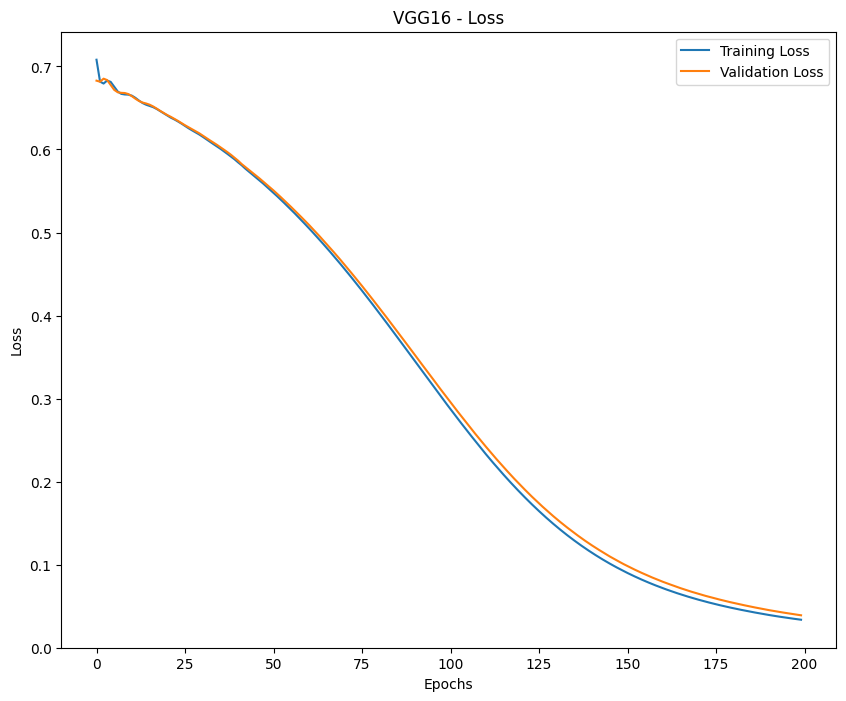

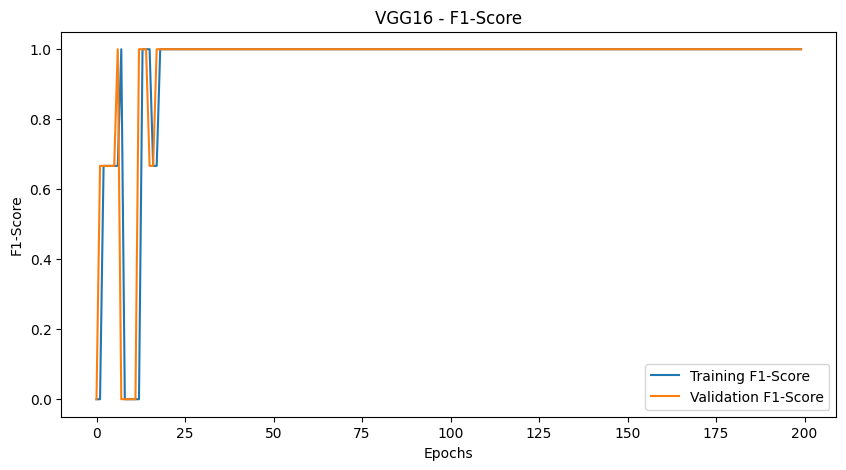

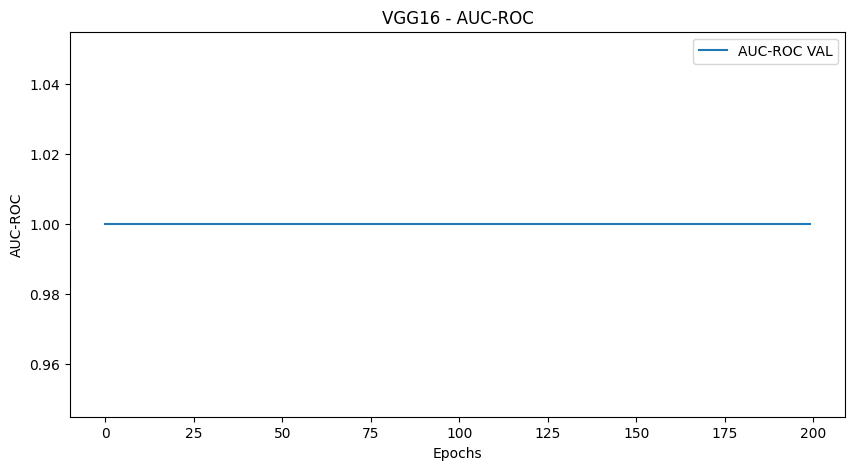

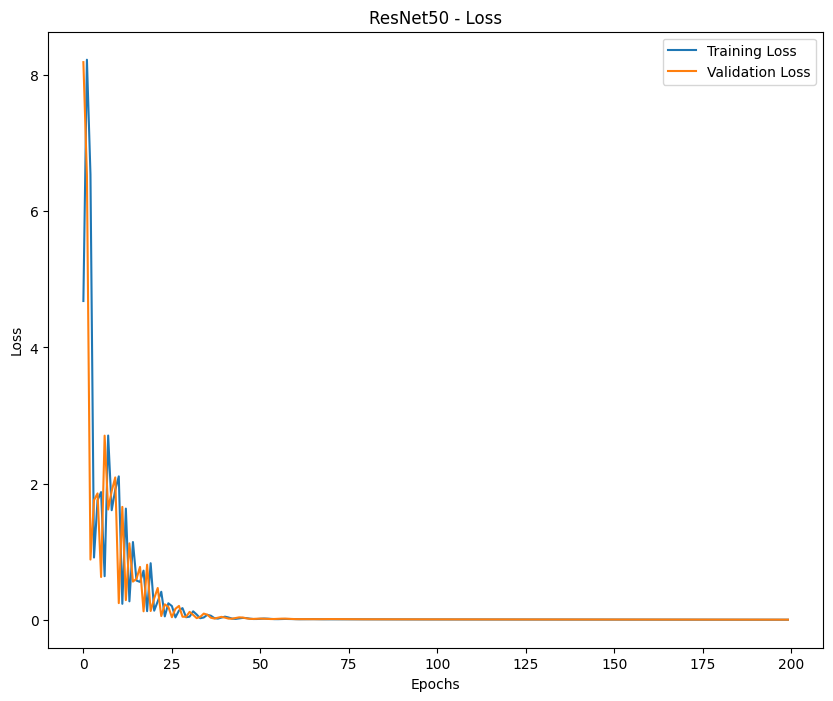

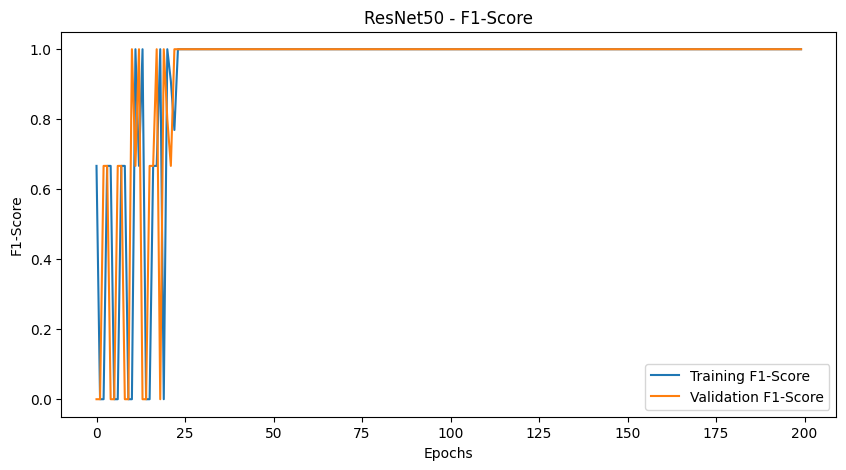

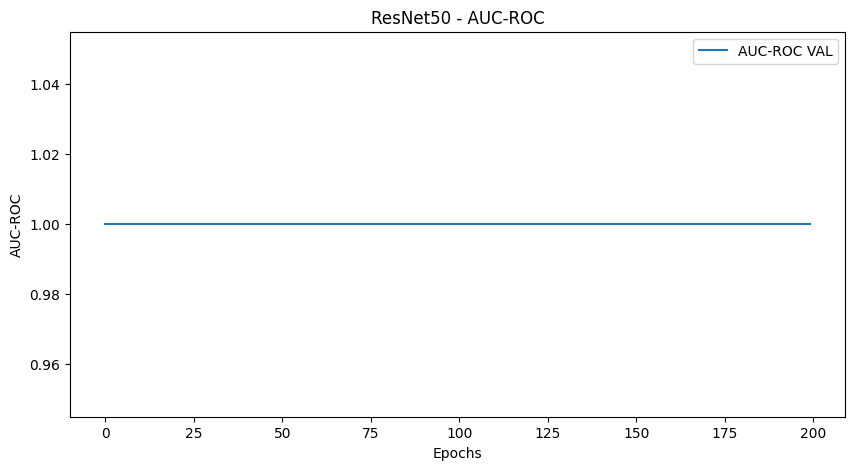

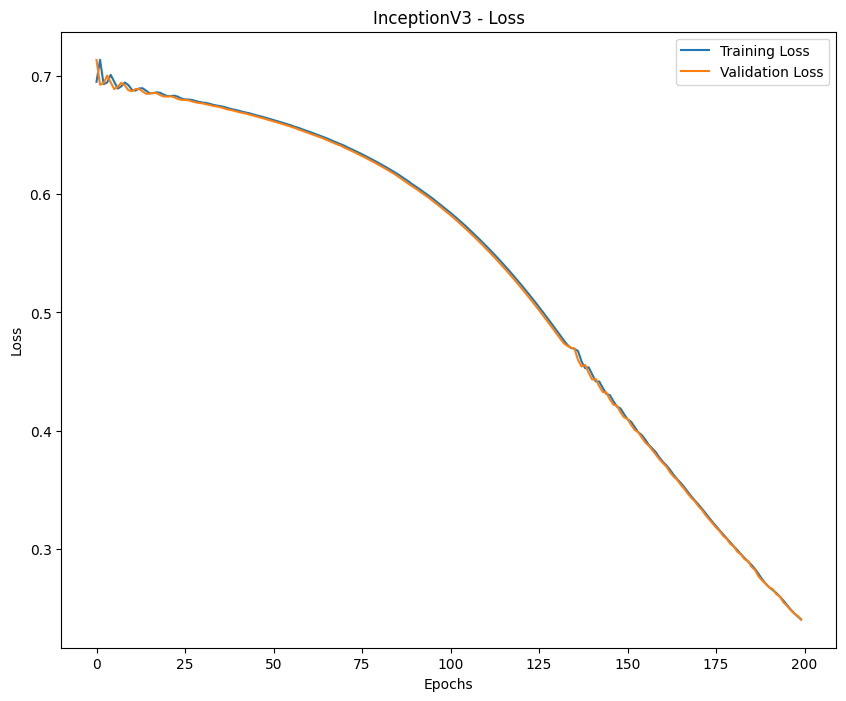

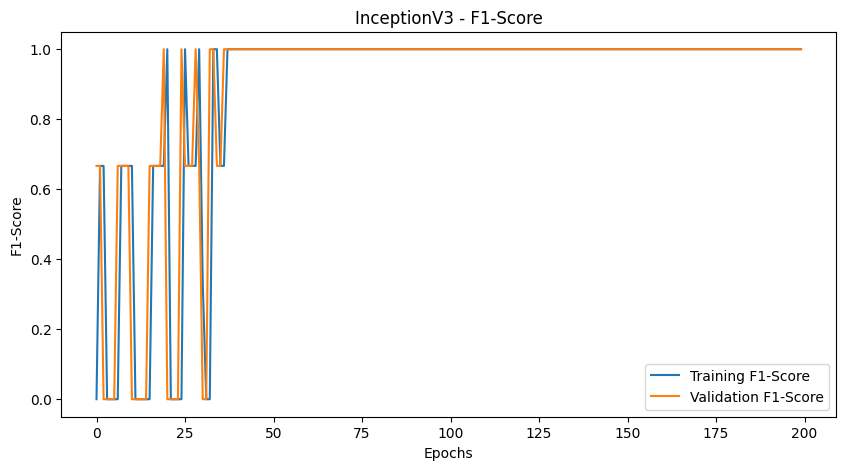

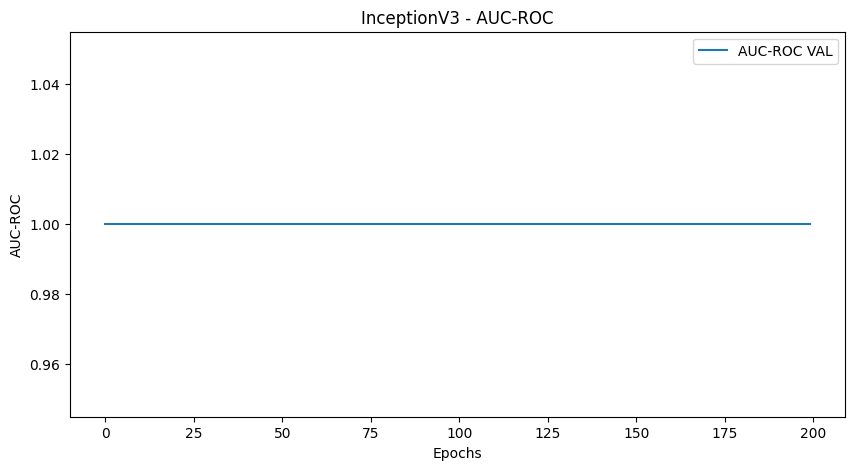

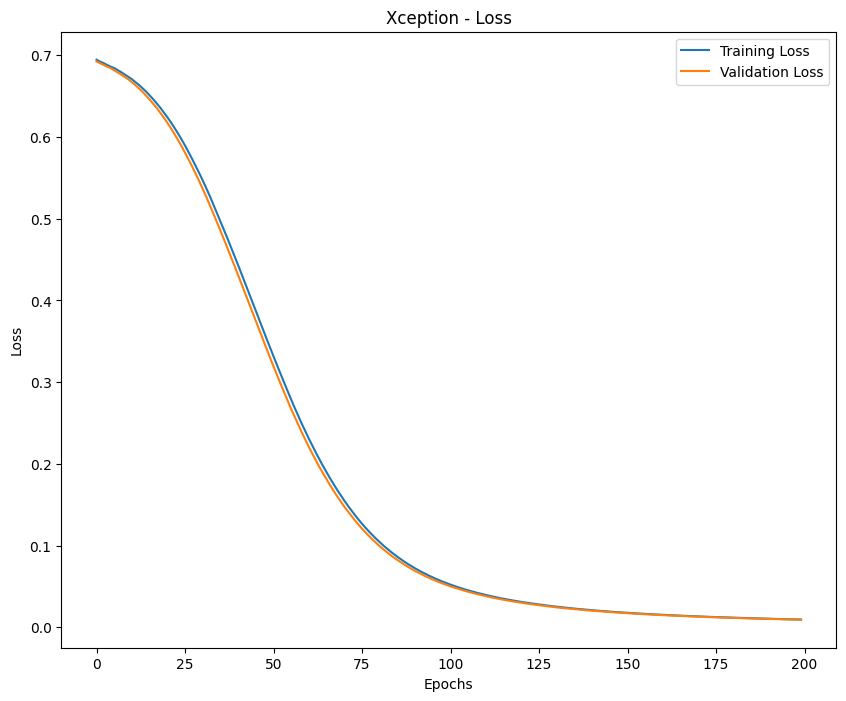

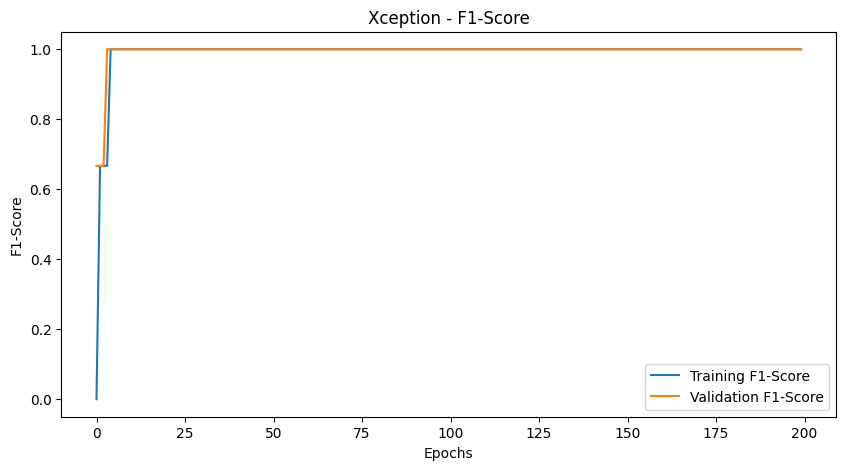

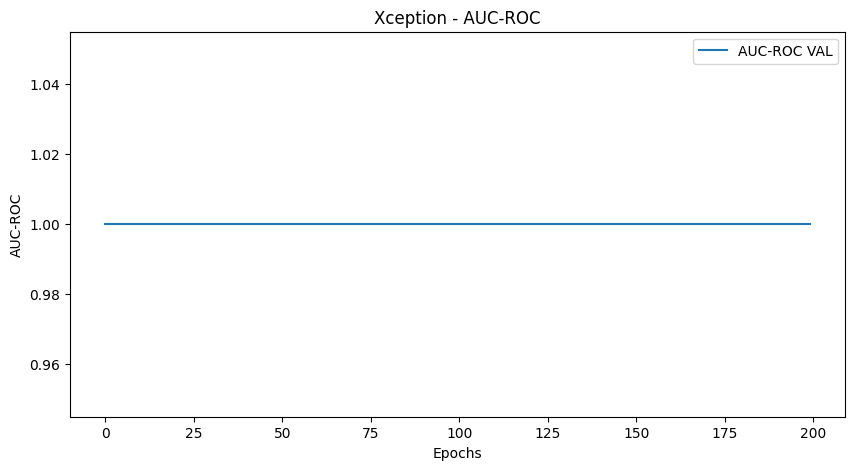

In [31]:
for index, row in df_k5.iterrows():
    model_name = row['Model']

    # Loss
    plt.figure(figsize=(10, 8))
    plt.plot(row['Loss'], label='Training Loss')
    plt.plot(row['Validation Loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.show()

    # F1-Score
    plt.figure(figsize=(10, 5))
    plt.plot(row['F1-Score'], label ='Training F1-Score')
    plt.plot(row['Validation F1-Score'], label='Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.title(f'{model_name} - F1-Score')
    plt.legend()
    plt.show()

    # AUC-ROC
    plt.figure(figsize=(10, 5))
    plt.plot(row['AUC-ROC VAL'], label ='AUC-ROC VAL')
    plt.xlabel('Epochs')
    plt.ylabel('AUC-ROC')
    plt.title(f'{model_name} - AUC-ROC')
    plt.legend()
    plt.show()

In [ ]:
for index, row in df_k10.iterrows():
    model_name = row['Model']

    # Loss
    plt.figure(figsize=(10, 8))
    plt.plot(row['Loss'], label='Training Loss')
    plt.plot(row['Validation Loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.show()

    # F1-Score
    plt.figure(figsize=(10, 5))
    plt.plot(row['F1-Score'], label ='Training F1-Score')
    plt.plot(row['Validation F1-Score'], label='Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.title(f'{model_name} - F1-Score')
    plt.legend()
    plt.show()

    # AUC-ROC
    plt.figure(figsize=(10, 5))
    plt.plot(row['AUC-ROC VAL'], label ='AUC-ROC VAL')
    plt.xlabel('Epochs')
    plt.ylabel('AUC-ROC')
    plt.title(f'{model_name} - AUC-ROC')
    plt.legend()
    plt.show()

In [ ]:
for index, row in df_k20.iterrows():
    model_name = row['Model']

    # Loss
    plt.figure(figsize=(10, 8))
    plt.plot(row['Loss'], label='Training Loss')
    plt.plot(row['Validation Loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.show()

    # F1-Score
    plt.figure(figsize=(10, 5))
    plt.plot(row['F1-Score'], label ='Training F1-Score')
    plt.plot(row['Validation F1-Score'], label='Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.title(f'{model_name} - F1-Score')
    plt.legend()
    plt.show()

    # AUC-ROC
    plt.figure(figsize=(10, 5))
    plt.plot(row['AUC-ROC VAL'], label ='AUC-ROC VAL')
    plt.xlabel('Epochs')
    plt.ylabel('AUC-ROC')
    plt.title(f'{model_name} - AUC-ROC')
    plt.legend()
    plt.show()

In [ ]:
# Speicherpfad für die Modelle USECASES
model_directory = "UseCases/"

# Aktuelles Datum und Uhrzeit erhalten USECASES
current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")